In [62]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline


# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

#for evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

## Load Data

In [63]:
df = DataReader('LUV', data_source='yahoo', start='2012-01-01', end=datetime.now())
df
#he adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions.

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,8.760000,8.410000,8.720000,8.410000,8808600.0,7.824934
2012-01-04,8.610000,8.220000,8.410000,8.600000,7582700.0,8.001719
2012-01-05,8.640000,8.390000,8.570000,8.620000,4892200.0,8.020328
2012-01-06,8.700000,8.520000,8.630000,8.520000,3046800.0,7.927283
2012-01-09,8.680000,8.520000,8.520000,8.590000,2906900.0,7.992411
...,...,...,...,...,...,...
2021-09-02,50.160000,49.040001,49.560001,49.599998,4966700.0,49.599998
2021-09-03,49.820000,48.669998,49.340000,48.860001,5201800.0,48.860001
2021-09-07,48.740002,47.990002,48.360001,48.529999,6474400.0,48.529999


## Data evaluation

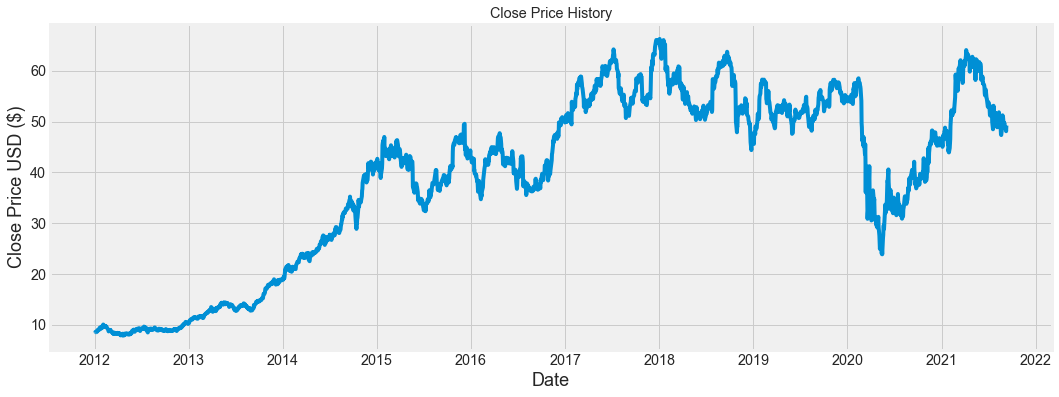

In [64]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Data preparation

In [65]:
# Create a new dataframe with only the 'Close column
#data= AAPL['Close'].values.reshape(-1, 1)
data = df.filter(['Close'])
data

,Close
Date,
2012-01-03,8.410000
2012-01-04,8.600000
2012-01-05,8.620000
2012-01-06,8.520000
2012-01-09,8.590000
...,...
2021-09-02,49.599998
2021-09-03,48.860001
2021-09-07,48.529999


In [66]:
# Convert the dataframe to a numpy array
dataset = data.values

In [67]:
dataset.shape

(2438, 1)

In [68]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [69]:
#split the data into train and test
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [70]:
train_data.shape

(2195, 1)

In [71]:
#split train data into train and val for the modeling

def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [72]:
train_1, val_1 = train_val(train_data)

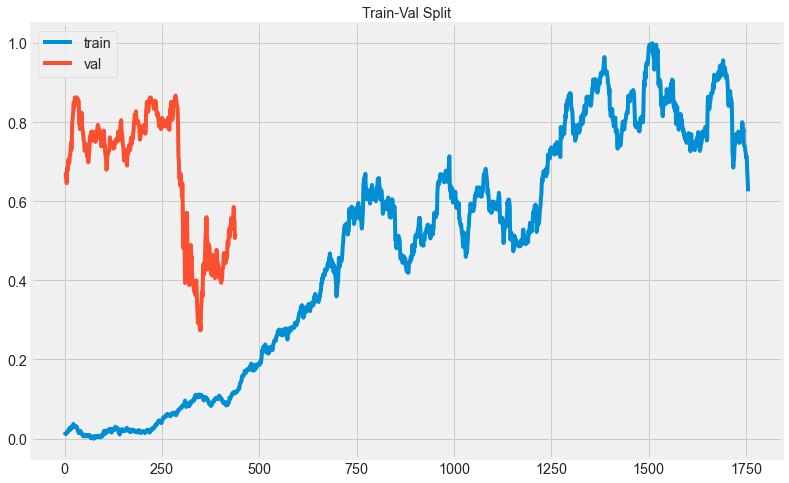

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_1, label='train')
ax.plot(val_1, label='val')
ax.set_title('Train-Val Split');
plt.legend();

In [74]:
#The LSTM needs data with the format of [samples, time steps and features]
#[10 20 30] 40
#[20 30 40] 50
#[30 40 50] 60
#using the size of time step as a batch to predict the next value 

def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [75]:
def prepare_training(data, n_steps):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequence(train, n_steps)
    x_val, y_val = split_sequence(val, n_steps)
    features = 1
    return x_train, y_train, x_val, y_val, features


In [80]:
n_steps = 10

x_train, y_train, x_val, y_val, feature = prepare_training(train_data,n_steps)

In [81]:
x_train.shape

(1746, 10, 1)

In [82]:
y_train.shape

(1746, 1)

## Modeling

In [76]:
#base Encoder-Decoder model
def creat_model1(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [77]:
#including dropout layers
def creat_model2(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


In [78]:
#Bidirectional allows the model learn the input sequence both forward and backwards
def creat_model3(n_steps, features):
    model = Sequential()
    model.add(LSTM(200, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=False)))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

An encoder-decoder LSTM is a model comprised of two sub-models: one called the encoder that reads the input sequences and compresses it to a fixed-length internal representation, and an output model called the decoder that interprets the internal representation and uses it to predict the output sequence. The encoder-decoder approach to sequence prediction has proven much more effective than outputting a vector directly

In [79]:
#Encoder-Decoder model
def creat_model4(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_steps, features), return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [83]:
#Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

## Test data set

In [84]:
test_data = scaled_data[training_data_len: , :]
x_test, y_test = split_sequence(test_data, n_steps)

In [85]:
y_test_re = scaler.inverse_transform(y_test)

In [86]:
y_test_re.shape

(233, 1)

## Model 1

In [87]:
model1 = creat_model1(n_steps, feature)

In [88]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 2s 25ms/step - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/50
35/35 [==============================] - 1s 20ms/step - loss: 3.7479e-04 - mean_squared_error: 3.7479e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4/50
35/35 [==============================] - 1s 20ms/step - loss: 3.7474e-04 - mean_squared_error: 3.7474e-04 - val_loss: 9.4736e-04 - val_mean_squared_error: 9.4736e-04
Epoch 5/50
35/35 [==============================] - 1s 19ms/step - loss: 3.6864e-04 - mean_squared_error: 3.6864e-04 - val_loss: 9.4775e-04 - val_mean_squared_error: 9.4775e-04
Epoch 6/50
35/35 [==============================] - 1s 19ms/step - loss: 3.1943e-04 - mean_squared_error: 3.1943e-04 - val_loss: 9.4495e-04 - val_mean_squa

In [89]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               66560     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Get the models predicted price values 
predictions1 = model1.predict(x_test)

In [91]:
predictions1.shape

(233, 1)

In [92]:
predictions1 = scaler.inverse_transform(predictions1)

In [93]:
# Get the root mean squared error (RMSE)
##import math
#math.sqrt(mean_squared_error(y_test_re,predictions))
rmse1 = np.sqrt(np.mean(((predictions1 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：1.5178


## Model 2

In [94]:
model2 = creat_model2(n_steps, feature)

In [95]:
history2 = model2.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 3s 29ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 2/50
35/35 [==============================] - 1s 16ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/50
35/35 [==============================] - 1s 16ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/50
35/35 [==============================] - 1s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/50
35/35 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 7/50
35/35 [================

In [96]:
predictions2 = model2.predict(x_test)

In [97]:
predictions2 = scaler.inverse_transform(predictions2)

In [98]:
rmse2 = np.sqrt(np.mean(((predictions2 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')

RMSE：2.1034


## Model 3

In [99]:
model3 = creat_model3(n_steps, feature)

In [100]:
history3 = model3.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 4s 68ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/50
35/35 [==============================] - 2s 57ms/step - loss: 8.5421e-04 - mean_squared_error: 8.5421e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/50
35/35 [==============================] - 2s 53ms/step - loss: 4.0829e-04 - mean_squared_error: 4.0829e-04 - val_loss: 9.8219e-04 - val_mean_squared_error: 9.8219e-04
Epoch 4/50
35/35 [==============================] - 2s 57ms/step - loss: 3.9950e-04 - mean_squared_error: 3.9950e-04 - val_loss: 9.3503e-04 - val_mean_squared_error: 9.3503e-04
Epoch 5/50
35/35 [==============================] - 2s 53ms/step - loss: 3.1376e-04 - mean_squared_error: 3.1376e-04 - val_loss: 9.0347e-04 - val_mean_squared_error: 9.0347e-04
Epoch 6/50
35/35 [==============================] - 2s 53ms/step - loss: 3.6760e-04 - mean_squared_error: 3.6760e-04 - val_loss: 9.1055e-04

In [101]:
predictions3 = model3.predict(x_test)

In [102]:
predictions3.shape

(233, 1)

In [103]:
predictions3 = scaler.inverse_transform(predictions3)

In [104]:
rmse3 = np.sqrt(np.mean(((predictions3 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse3, 4)}')

RMSE：1.4179


## Model 4

In [105]:
model4 = creat_model4(n_steps, feature)

In [106]:
history4 = model4.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 3s 37ms/step - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/50
35/35 [==============================] - 1s 28ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 3/50
35/35 [==============================] - 1s 27ms/step - loss: 8.3966e-04 - mean_squared_error: 8.3966e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/50
35/35 [==============================] - 1s 28ms/step - loss: 7.0356e-04 - mean_squared_error: 7.0356e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/50
35/35 [==============================] - 1s 29ms/step - loss: 6.9161e-04 - mean_squared_error: 6.9161e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/50
35/35 [==============================] - 1s 31ms/step - loss: 6.4550e-04 - mean_squared_error: 6.4550e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Ep

In [107]:
predictions4 = model4.predict(x_test)

In [108]:
predictions4 = scaler.inverse_transform(predictions4)

In [109]:
rmse4 = np.sqrt(np.mean(((predictions4 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse4, 4)}')

RMSE：1.8829


## Visual evaluation for the best model

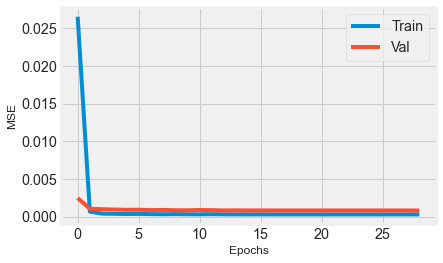

In [110]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

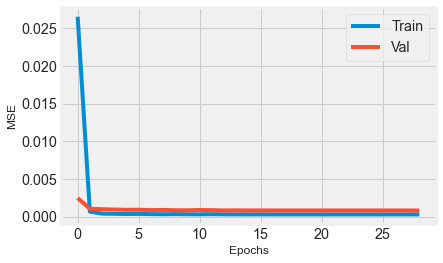

In [111]:
plt.plot(history3.history['mean_squared_error'])
plt.plot(history3.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

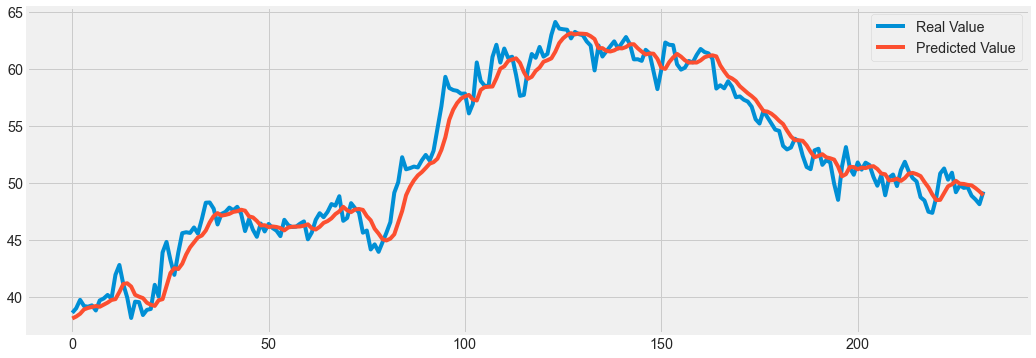

In [112]:
plt.figure(figsize=(16,6))
plt.plot(y_test_re)
plt.plot(predictions3)
plt.legend(['Real Value','Predicted Value']);

In [113]:
train = data[:training_data_len]
test = data[training_data_len+10:]

In [117]:
predictions3.shape

(233, 1)

In [118]:
test['Predictions'] = predictions3

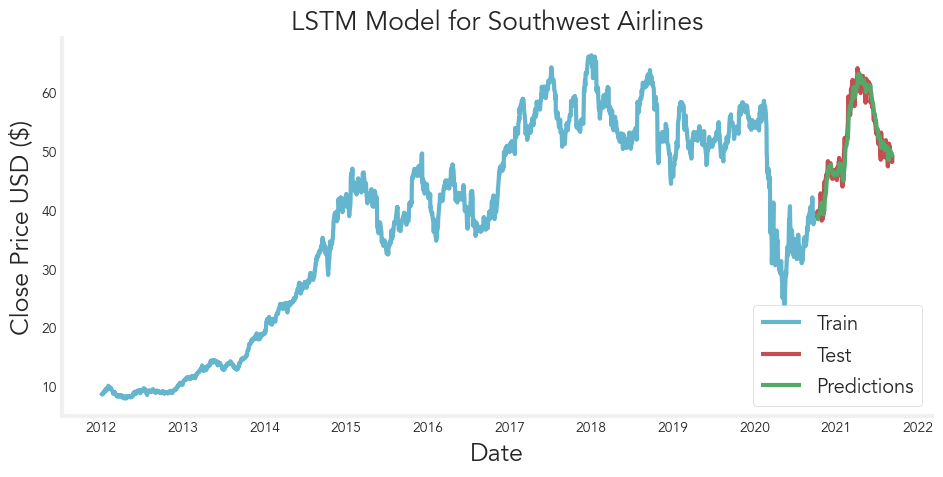

In [123]:
with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(10,5), dpi=100)
    plt.title('LSTM Model for Southwest Airlines')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], 'c')
    plt.plot(test['Close'], 'r')
    plt.plot(test['Predictions'], 'g')
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.savefig('images/LSTM.png')
    plt.show()
    
    

In [120]:
test

,Close,Predictions
Date,,
2020-10-07,38.590000,38.097610
2020-10-08,38.990002,38.267063
2020-10-09,39.730000,38.509888
2020-10-12,39.189999,38.892204
2020-10-13,39.130001,39.021717
...,...,...
2021-09-02,49.599998,49.813580
2021-09-03,48.860001,49.769230
2021-09-07,48.529999,49.529331
